# 📈 Stock Price Prediction - Base Training Model

## 📝 Introduction  
This notebook serves as the **base training framework** for **predicting stock price movements** using **historical financial data** from **Yahoo Finance**.  
It will act as a **reference point** for future enhancements and model improvements.  

---

## 🎯 Task Description  
This work is part of the **Dataguess Technologies' Machine Learning Engineer Assignment**.  
The objective is to build a **predictive model** that forecasts **future stock price movements** based on past trends.  

This **initial training setup** will be iteratively improved in future versions. 🚀  

## 📌 Importing Required Libraries

Before analyzing stock market data, we need to set up the required libraries and dependencies.

- `%%capture`: Suppresses unnecessary output when running commands.
- `!pip install yfinance`: Installs the `yfinance` package for fetching stock data.
- `pandas`: Handles data manipulation and DataFrames.
- `seaborn` & `matplotlib`: Used for data visualization and plotting.
- `yfinance`: Retrieves stock market data from Yahoo Finance.
- `datetime`: Manages date and time operations.
- `numpy`: Provides numerical computing support.
- `itertools`: Helps generate stock pair combinations for correlation analysis.
- `IPython.display`: Enhances table and DataFrame visualization in Jupyter notebooks.

This setup ensures we have the **necessary tools for stock price analysis, visualization, and machine learning modeling.** 🚀

In [1]:
%%capture
!pip install yfinance

import pandas   as pd             
import seaborn  as sns           
import matplotlib.pyplot as plt   
import yfinance as yf 
from datetime import datetime
import numpy as np
from itertools import combinations
from IPython.display import display
import warnings

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

## 📌 Defining Stock Symbols & Data Fetching Parameters

To analyze stock market data, we define a list of **technology company stocks** and set the parameters for data retrieval.

- **`tech_list`**: A list of stock symbols from major technology companies:
  - `AAPL` - Apple Inc.
  - `GOOG` - Alphabet (Google)
  - `MSFT` - Microsoft Corporation
  - `AMZN` - Amazon.com Inc.

- **Data Fetching Parameters**:
  - **`yf_period = "1y"`** → Fetches data for the **last 1 year**.
  - **`yf_interval = "1d"`** → Retrieves **daily stock price data**.

These settings ensure that we obtain **daily stock price movements for the past year**, allowing us to analyze trends and develop predictive models. 📊

In [2]:
# List of technology stocks to analyze
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Data fetching parameters
yf_period = "10y"   # Last 1 year of data
yf_interval = "1d"  # Daily interval
CHOICE = "MICROSOFT"

BATCH_SIZE = 32
EPOCHS = 100
SEQ_LEN = 11

valid_set_size_percentage = 10 
test_set_size_percentage = 10 

## 🔹 Data Loading  

In [3]:
# Create an empty dictionary to store stock data
data_dict = {}

# Download and merge data for each stock
for stock in tech_list:
    data = yf.download(stock, period=yf_period, interval=yf_interval)
    
    # Rename columns to avoid MultiIndex issues
    data = data.add_suffix(f"_{stock}")
    
    # Store the data in the dictionary
    data_dict[stock] = data

# Concatenate all stock data horizontally (axis=1)
df = pd.concat(data_dict.values(), axis=1)

# Display the first few rows
df.head(10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Adj Close_AAPL,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL,Adj Close_GOOG,Close_GOOG,High_GOOG,Low_GOOG,...,High_MSFT,Low_MSFT,Open_MSFT,Volume_MSFT,Adj Close_AMZN,Close_AMZN,High_AMZN,Low_AMZN,Open_AMZN,Volume_AMZN
Ticker,AAPL_AAPL,AAPL_AAPL,AAPL_AAPL,AAPL_AAPL,AAPL_AAPL,AAPL_AAPL,GOOG_GOOG,GOOG_GOOG,GOOG_GOOG,GOOG_GOOG,...,MSFT_MSFT,MSFT_MSFT,MSFT_MSFT,MSFT_MSFT,AMZN_AMZN,AMZN_AMZN,AMZN_AMZN,AMZN_AMZN,AMZN_AMZN,AMZN_AMZN
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-02,26.418234,29.657499,29.792500,29.020000,29.512501,250956400,26.257307,26.351652,26.577032,25.856510,...,41.369999,40.230000,40.590000,50352500,18.223499,18.223499,18.250000,17.500500,17.502501,204638000
2015-02-03,26.422684,29.662500,29.772499,29.402500,29.625000,207662800,26.295067,26.389547,26.596977,26.091366,...,41.930000,41.049999,41.630001,52082400,18.177500,18.177500,18.391001,18.010500,18.014500,124252000
2015-02-04,26.625332,29.889999,30.127501,29.577499,29.625000,280598800,25.973110,26.066435,26.560678,25.992140,...,42.209999,41.360001,41.939999,41614800,18.237499,18.237499,18.375000,17.911501,17.919001,83398000
2015-02-05,26.815372,29.985001,30.057501,29.812500,30.004999,168984800,26.212591,26.306774,26.352650,26.033026,...,42.639999,41.860001,42.220001,36548200,18.694500,18.694500,18.940001,18.295000,18.299999,144952000
2015-02-06,26.589563,29.732500,30.062500,29.612499,30.004999,174826400,26.382511,26.477306,26.786457,26.248434,...,42.790001,42.150002,42.680000,34616600,18.714001,18.714001,18.799500,18.550501,18.743500,77848000
2015-02-09,26.766186,29.930000,29.959999,29.607500,29.637501,155559200,26.225010,26.319241,26.527170,26.228989,...,42.740002,42.209999,42.240002,31381100,18.528000,18.528000,18.720501,18.360001,18.549999,54492000
2015-02-10,27.280405,30.504999,30.537500,30.040001,30.042500,248034000,26.677637,26.773493,26.811390,26.273865,...,42.770000,42.180000,42.740002,29670700,18.650000,18.650000,18.715000,18.425501,18.559500,45744000
2015-02-11,27.919825,31.219999,31.230000,30.625000,30.692499,294247200,26.629444,26.725126,26.848787,26.595881,...,42.650002,42.209999,42.650002,38262500,18.757000,18.757000,18.855000,18.555000,18.561501,55730000


In [4]:
# If column names are tuples (MultiIndex), flatten them
if isinstance(df.columns, pd.MultiIndex):
    df.columns = ['_'.join(col).strip() for col in df.columns.values]

In [5]:
# Extract data separately for each stock
aapl_df = df.filter(like="_AAPL")  # Select columns ending with "_AAPL"
goog_df = df.filter(like="_GOOG")  # Select columns ending with "_GOOG"
msft_df = df.filter(like="_MSFT")  # Select columns ending with "_MSFT"
amzn_df = df.filter(like="_AMZN")  # Select columns ending with "_AMZN"

# Clean column names (e.g., change "Close_AAPL" to "Close")
aapl_df.columns = [col.replace("_AAPL", "") for col in aapl_df.columns]
goog_df.columns = [col.replace("_GOOG", "") for col in goog_df.columns]
msft_df.columns = [col.replace("_MSFT", "") for col in msft_df.columns]
amzn_df.columns = [col.replace("_AMZN", "") for col in amzn_df.columns]

# Display basic statistics for AAPL
print("📊 AAPL Stock Statistics")
display(aapl_df.describe())

print("\n📌 AAPL Data Information")
display(aapl_df.info())

# Display basic statistics for GOOG
print("\n📊 GOOG Stock Statistics")
display(goog_df.describe())

print("\n📌 GOOG Data Information")
display(goog_df.info())


📊 AAPL Stock Statistics


,Adj Close,Close,High,Low,Open,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,95.952337,98.008856,98.965116,96.949578,97.923595,1.154886e+08
std,66.610727,66.108631,66.724589,65.408227,66.042160,6.685932e+07
min,20.697264,22.584999,22.917500,22.367500,22.500000,2.323470e+07
25%,35.938533,38.333124,38.567500,38.020625,38.405626,7.040315e+07
50%,67.703953,69.752499,70.439999,69.213749,69.417503,9.895455e+07
75%,152.510941,154.502499,156.337502,152.729996,154.132496,1.407809e+08
max,259.019989,259.019989,260.100006,257.630005,258.190002,6.488252e+08



📌 AAPL Data Information
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2015-02-02 to 2025-01-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2516 non-null   float64
 1   Close      2516 non-null   float64
 2   High       2516 non-null   float64
 3   Low        2516 non-null   float64
 4   Open       2516 non-null   float64
 5   Volume     2516 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.6 KB


None


📊 GOOG Stock Statistics


,Adj Close,Close,High,Low,Open,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,83.878049,84.154009,85.006735,83.272176,84.099586,3.050487e+07
std,45.284048,45.392823,45.886878,44.913738,45.367794,1.523515e+07
min,25.748981,25.841499,26.136700,25.759001,25.975000,6.809800e+06
25%,46.773562,46.941625,47.134126,46.466000,46.814251,2.107330e+07
50%,65.796337,66.032753,66.760227,65.595001,66.314503,2.676500e+07
75%,122.519773,122.960001,124.022499,121.543753,122.570751,3.530250e+07
max,205.600006,205.600006,207.080002,203.580002,203.714996,2.232980e+08



📌 GOOG Data Information
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2015-02-02 to 2025-01-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2516 non-null   float64
 1   Close      2516 non-null   float64
 2   High       2516 non-null   float64
 3   Low        2516 non-null   float64
 4   Open       2516 non-null   float64
 5   Volume     2516 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.6 KB


None

In [6]:
# Function to analyze missing values in each dataset
def missing_values_info(df, company_name):
    missing_values = df.isna().sum()
    missing_percentage = (df.isna().sum() / len(df)) * 100
    
    missing_df = pd.DataFrame({
        "Column": df.columns,
        "Missing Values": missing_values.values,
        "Missing Percentage (%)": missing_percentage.values
    })
    
    return missing_df

# Compute missing value statistics for each company
aapl_missing = missing_values_info(aapl_df, "APPLE")
goog_missing = missing_values_info(goog_df, "GOOGLE")
msft_missing = missing_values_info(msft_df, "MICROSOFT")
amzn_missing = missing_values_info(amzn_df, "AMAZON")

print("\n📌 Missing Value Analysis")
display(aapl_missing, goog_missing, msft_missing, amzn_missing)


📌 Missing Value Analysis


,Column,Missing Values,Missing Percentage (%)
0,Adj Close,0,0.0
1,Close,0,0.0
2,High,0,0.0
3,Low,0,0.0
4,Open,0,0.0
5,Volume,0,0.0


,Column,Missing Values,Missing Percentage (%)
0,Adj Close,0,0.0
1,Close,0,0.0
2,High,0,0.0
3,Low,0,0.0
4,Open,0,0.0
5,Volume,0,0.0


,Column,Missing Values,Missing Percentage (%)
0,Adj Close,0,0.0
1,Close,0,0.0
2,High,0,0.0
3,Low,0,0.0
4,Open,0,0.0
5,Volume,0,0.0


,Column,Missing Values,Missing Percentage (%)
0,Adj Close,0,0.0
1,Close,0,0.0
2,High,0,0.0
3,Low,0,0.0
4,Open,0,0.0
5,Volume,0,0.0


In [7]:
company_data = {
    "APPLE": aapl_df,
    "GOOGLE": goog_df,
    "MICROSOFT": msft_df,
    "AMAZON": amzn_df
}

In [8]:
# Amazon veri setini seçme
df = company_data[CHOICE]

## 🔹 Splitting the Dataset  


In [9]:
_5d = df[['Volume','High','Low','Open', 'Close']].copy(deep=True)


In [10]:
scaler = MinMaxScaler(feature_range=(0,2)).fit(_5d.Low.values.reshape(-1,1))
_5d['Open'] = scaler.transform(_5d.Open.values.reshape(-1,1))
_5d['High'] = scaler.transform(_5d.High.values.reshape(-1,1))
_5d['Low'] = scaler.transform(_5d.Low.values.reshape(-1,1))
_5d['Close'] = scaler.transform(_5d.Close.values.reshape(-1,1))
_5d['Volume'] = scaler.transform(_5d.Volume.values.reshape(-1,1))

In [11]:
data_5d = _5d[['Open','High','Low','Close']].values


In [12]:
seq_len= SEQ_LEN
sequences_5d=[]
for index in range(len(data_5d) - seq_len + 1): 
    sequences_5d.append(data_5d[index: index + seq_len])
sequences_5d = np.array(sequences_5d)
print(sequences_5d.shape)

(2506, 11, 4)


In [13]:
valid_set_size_5d = int(np.round(valid_set_size_percentage/100*sequences_5d.shape[0]))  
test_set_size_5d  = int(np.round(test_set_size_percentage/100*sequences_5d.shape[0]))
train_set_size_5d = sequences_5d.shape[0] - (valid_set_size_5d + test_set_size_5d)

x_train_5d = sequences_5d[:train_set_size_5d,:-1,:]
y_train_5d = sequences_5d[:train_set_size_5d,-1,:]
    
x_valid_5d = sequences_5d[train_set_size_5d:train_set_size_5d+valid_set_size_5d,:-1,:]
y_valid_5d = sequences_5d[train_set_size_5d:train_set_size_5d+valid_set_size_5d,-1,:]
    
x_test_5d = sequences_5d[train_set_size_5d+valid_set_size_5d:,:-1,:]
y_test_5d = sequences_5d[train_set_size_5d+valid_set_size_5d:,-1,:]

In [14]:
x_train_5d.shape

(2004, 10, 4)

In [15]:
x_train_5d = torch.tensor(x_train_5d).float()
y_train_5d = torch.tensor(y_train_5d).float()

x_valid_5d = torch.tensor(x_valid_5d).float()
y_valid_5d = torch.tensor(y_valid_5d).float()

train_dataset_5d = TensorDataset(x_train_5d,y_train_5d)
train_dataloader_5d = DataLoader(train_dataset_5d, batch_size=BATCH_SIZE, shuffle=False)

valid_dataset_5d = TensorDataset(x_valid_5d,y_valid_5d)
valid_dataloader_5d = DataLoader(valid_dataset_5d, batch_size=BATCH_SIZE, shuffle=False)


In [16]:
x_train_5d.shape

torch.Size([2004, 10, 4])

## 🔹 Model Training

In [17]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_feature):
        super(NeuralNetwork, self).__init__()
        self.lstm  = nn.LSTM(num_feature,64,batch_first=True)
        self.fc    = nn.Linear(64,num_feature)
        
        
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        x = self.fc(hidden)
        return x

In [18]:
model_5d = NeuralNetwork(4)
optimizer = optim.Adam(model_5d.parameters())
mse = nn.MSELoss()

In [19]:
def train(dataloader):
    epoch_loss = 0
    model_5d.train()  
    
    for batch in dataloader:
        optimizer.zero_grad()          
        x,y= batch
        pred = model_5d(x)
        loss = mse(pred[0],y)        
        loss.backward()               
        optimizer.step()      
        epoch_loss += loss.item()  
        
    return epoch_loss

def evaluate(dataloader):
    epoch_loss = 0
    model_5d.eval()  
    
    with torch.no_grad():
        for batch in dataloader:   
            x,y= batch
            pred = model_5d(x)
            loss = mse(pred[0],y)              
            epoch_loss += loss.item()  
        
    return epoch_loss / len(dataloader)

In [20]:
best_valid_loss_5d = float('inf')

for epoch in range(1, EPOCHS + 1):

    train_loss_5d = train(train_dataloader_5d)
    valid_loss_5d = evaluate(valid_dataloader_5d)
    
    #save the best model
    if valid_loss_5d < best_valid_loss_5d:
        best_valid_loss_5d = valid_loss_5d
        torch.save(model_5d, 'saved_weights_5d.pt')

    # print("Epoch ",epoch+1)
    print(f'\tTrain Loss: {train_loss_5d:.5f} | ' + f'\tVal Loss: {valid_loss_5d:.5f}\n')

	Train Loss: 0.38854 | 	Val Loss: 0.29094

	Train Loss: 3.36477 | 	Val Loss: 0.12717

	Train Loss: 4.61970 | 	Val Loss: 0.02497

	Train Loss: 2.48826 | 	Val Loss: 0.02452

	Train Loss: 0.56230 | 	Val Loss: 0.02375

	Train Loss: 0.28577 | 	Val Loss: 0.01875

	Train Loss: 0.14926 | 	Val Loss: 0.01588

	Train Loss: 0.11376 | 	Val Loss: 0.01457

	Train Loss: 0.11283 | 	Val Loss: 0.01498

	Train Loss: 0.12802 | 	Val Loss: 0.01668

	Train Loss: 0.15956 | 	Val Loss: 0.01887

	Train Loss: 0.21902 | 	Val Loss: 0.01985

	Train Loss: 0.30122 | 	Val Loss: 0.01841

	Train Loss: 0.35997 | 	Val Loss: 0.01594

	Train Loss: 0.36215 | 	Val Loss: 0.01406

	Train Loss: 0.33720 | 	Val Loss: 0.01299

	Train Loss: 0.29794 | 	Val Loss: 0.01213

	Train Loss: 0.24880 | 	Val Loss: 0.01131

	Train Loss: 0.21004 | 	Val Loss: 0.01062

	Train Loss: 0.18173 | 	Val Loss: 0.01004

	Train Loss: 0.16367 | 	Val Loss: 0.00958

	Train Loss: 0.15370 | 	Val Loss: 0.00922

	Train Loss: 0.14947 | 	Val Loss: 0.00892

	Train Loss

In [21]:
model_5d =torch.load('saved_weights_5d.pt')

<ipython-input-21-ee2b0552d156>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_5d =torch.load('saved_weights_5d.pt')


In [22]:
x_test_5d = torch.tensor(x_test_5d).float()

with torch.no_grad():
    y_test_pred_5d = model_5d(x_test_5d)

y_test_pred_5d = y_test_pred_5d.numpy()[0]

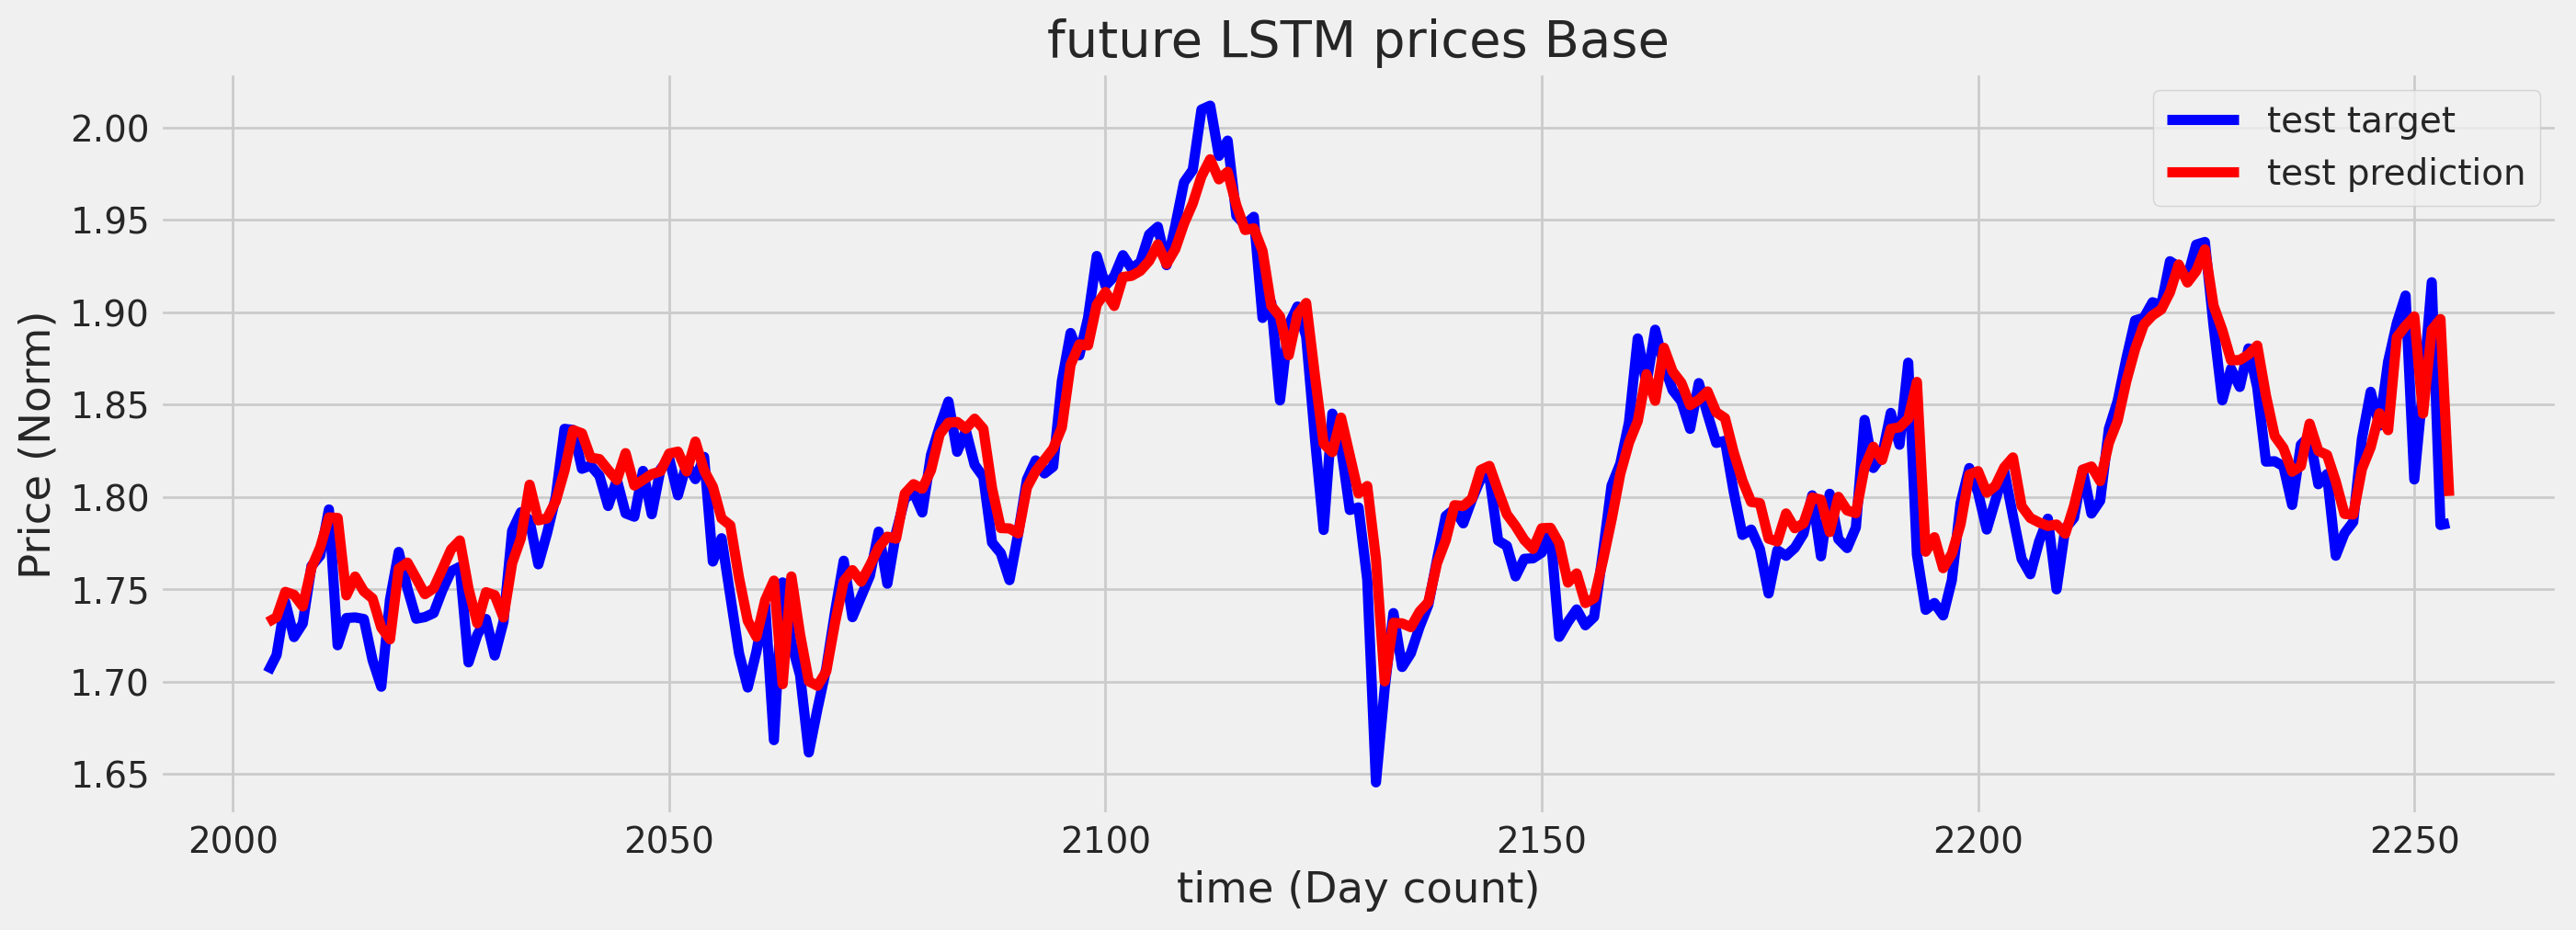

In [23]:
idx=0
plt.figure(figsize=(15,5), dpi=200)
plt.plot(np.arange(y_train_5d.shape[0], y_train_5d.shape[0]+y_test_5d.shape[0]),
         y_test_5d[:,idx], color='blue', label='test target')

plt.plot(np.arange(y_train_5d.shape[0], y_train_5d.shape[0]+y_test_pred_5d.shape[0]),
         y_test_pred_5d[:,idx], color='red', label='test prediction')

plt.title('future LSTM prices Base')
plt.xlabel('time (Day count)')
plt.ylabel('Price (Norm)')
plt.legend(loc='best')
plt.plot()
